# News Articles Clustering
## Name: Kuan-Cheng Fu

## Chapter 1 Introduction
In this project, we will be working with **about 15,000 articles** which are from **N categories**. Therefore, the goal of this project is to develop a framework which is capable of clustering articles based on their text contents.
Basically, we will apply several techniques such as TFIDF, cosine similarity, truncated SVD, and k-means clustering
to this project.

In [1]:
# Import package
import numpy as np
import pandas as pd 
import nltk
import re
import string
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load data
raw_articles_data = pd.read_csv('data/articles_raw.csv')
raw_articles_data

,id,title,text,date
0,1247638,Triple W to Feature DFree at CES 2019 - First ...,jan. according to the u. s. national institute...,2019-01-03
1,1247639,Pundi X Coin Review: Should You Invest in the ...,the npxs token developer aim to have ethereum ...,2019-01-06
2,1247641,Pundi X 1-Day Trading Volume Reaches $1.04 Mil...,pundi x (currency:npxs) traded 2. u dollar dur...,2019-01-02
3,1247642,Pundi X Hits Market Capitalization of $74.35 M...,pundi x (currency:npxs) traded 0. pm eastern o...,2019-01-04
4,1247643,Pundi X (NPXS) Market Cap Reaches $73.89 Million,pundi x (currency:npxs) traded down 0. u dolla...,2019-01-03
...,...,...,...,...
11182,1388717,NaN,microsoft for the mixed reality partnership pr...,2019-01-02
11183,1388718,NaN,ar (ar) app that convert any room to a virtual...,2019-01-09
11184,1388738,Intercellular is an Educational Experience Tak...,there nothing like a good educational vr (vr) ...,2019-02-13
11185,1388746,Wonderfall Mixes VR and Actual Reality For An ...,"it got a lot of vr and ar exhibit right now, n...",2019-01-30


## Chapter 2 Framework
### 2.1 Text Processing and TF-IDF Matrix
In this section, we first create a function to process and tokenize text contents. After that, we create a function to compute a sparse TFIDF matrix from the text contents. These functions will be executed step by step as follows.

In [3]:
# Create function to process and tokenize raw texts
def preprocess(text, stopwords={}, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    # Lower case
    text = text.lower()
    # Handle URL
    text = re.sub(r"https?://t.co/\w{10}",' ', text)
    # Deal with "'s" 
    text = re.sub(r"'s", "", text)
    # Deal with "'" 
    translator2 = str.maketrans({key: None for key in string.punctuation[6]})
    text = text.translate(translator2) 
    # Deal with the rest of punctuations
    translator3 = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(translator3)
    # Handle unicode
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    # Split the text
    r1 = nltk.word_tokenize(text)
    # Lemmatize the text
    r2 = [lemmatizer.lemmatize(word) for word in r1]
    # Remove the stopwords
    r3 = [word for word in r2 if not word in stopwords]
    # Remove digits
    r4 = [word for word in r3 if word.isalpha()]
    return r4

In [4]:
# Import NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
extra_stopwords = set()
stopwords = set(nltk.corpus.stopwords.words('english')) | extra_stopwords

[nltk_data] Downloading package stopwords to /Users/fufu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/fufu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/fufu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Put the preprocessed texts into a list
articles = []
for i in range(0,raw_articles_data.shape[0]):
    tokenized_text = preprocess(raw_articles_data['text'][i], stopwords)
    articles.append(' '.join(tokenized_text))

In [6]:
# Create function to build a sparse TFIDF matrix
def tfidf(docs):    
    document_words = [doc.split() for doc in docs]
    vocab = sorted(set(sum(document_words, [])))
    vocab_dict = {k:i for i,k in enumerate(vocab)}
    X_tf = np.zeros((len(docs), len(vocab)), dtype=int)
    for i,doc in enumerate(document_words):
        for word in doc:
            X_tf[i, vocab_dict[word]] += 1
            
    idf = np.log(X_tf.shape[0]/X_tf.astype(bool).sum(axis=0))
    X_tfidf = X_tf * idf
    tfidf = sp.csr_matrix(X_tfidf)
    all_words = vocab
    return(tfidf,all_words)    

In [7]:
# Compute a TFIDF matrix for the texts and normalize the matrix
X_tfidf, words = tfidf(articles)
tf_idf_norm = normalize(X_tfidf)

### 2.2 Dimensionality Reduction and Clustering (1)
After having the normalized TFIDF matrix, the dimensionality reduction will be performed using truncated SVD with 100 components. Next, we create a function to select optimal k value of k-means clustering using silhouette method. Finally, we create a function to cluster the articles using k-means clustering with k clusters and further plot the position of the articles in 2D space.

In [8]:
# Perform dimensionality reduction on the normalized TFIDF matrix by using truncated SVD
svd_model = TruncatedSVD(n_components=100, algorithm='randomized')
svd_matrix = svd_model.fit_transform(tf_idf_norm)

In [9]:
# Create function to select the optimal k value of k-means clustering with silhouette method
def plot_sil(df, kmax=30): 
    sil = []
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters=k, max_iter=600, algorithm='auto').fit(df)
        labels = kmeans.labels_
        sil.append(silhouette_score(df, labels, metric='euclidean')) 

    plt.plot(range(2, kmax+1), sil)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Silhouette Method')
    plt.grid()
    plt.show()  

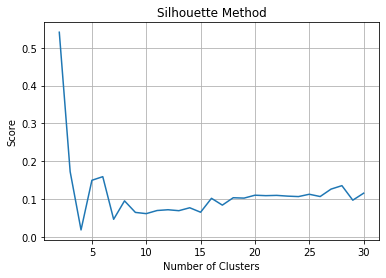

In [14]:
# Determine the optimal k value by identifying the highest score
random_state=0xCAFE
plot_sil(svd_matrix, kmax=30)

In [15]:
# Create function to cluster the texts and plot the position of the texts in 2D space 
def plot_and_predict(df, n_clusters=2, random_state=0xCAFE):

    kmeans = KMeans(n_clusters=n_clusters, max_iter=600, algorithm='auto')
    fitted = kmeans.fit(df)
    prediction = kmeans.predict(df)
    
    plot_matrix = TruncatedSVD(n_components=2, algorithm='randomized', random_state=random_state).fit_transform(df)
    
    fig, ax = plt.subplots(figsize=(12,6))
    for c in range(n_clusters):
        ax.scatter(plot_matrix[prediction==c][:,0], plot_matrix[prediction==c][:,1], label=c, alpha=0.8, edgecolors='none')

    ax.legend()
    ax.grid(True)
    plt.show()
    
    return prediction

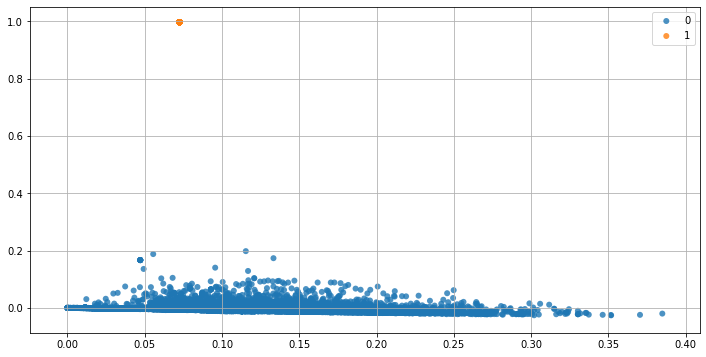

In [17]:
# Show the clustering result in 2D space 
prediction = plot_and_predict(svd_matrix, n_clusters=2)

In [18]:
# Show the raw texts in these two groups
n_clusters = 2
for i in range(n_clusters):
    print('%d, The raw texts in group %d:'%(i,i))
    result = raw_articles_data[prediction==i]['text']   
    display(result)

0, The raw texts in group 0:


0        jan. according to the u. s. national institute...
1        the npxs token developer aim to have ethereum ...
2        pundi x (currency:npxs) traded 2. u dollar dur...
3        pundi x (currency:npxs) traded 0. pm eastern o...
4        pundi x (currency:npxs) traded down 0. u dolla...
                               ...                        
11182    microsoft for the mixed reality partnership pr...
11183    ar (ar) app that convert any room to a virtual...
11184    there nothing like a good educational vr (vr) ...
11185    it got a lot of vr and ar exhibit right now, n...
11186    immersive technology adoption rate have steadi...
Name: text, Length: 11078, dtype: object

1, The raw texts in group 1:


256      please read the rule before joining the discus...
379      please read the rule before joining the discus...
383      please read the rule before joining the discus...
634      please read the rule before joining the discus...
635      please read the rule before joining the discus...
                               ...                        
9933     please read the rule before joining the discus...
10109    please read the rule before joining the discus...
10117    please read the rule before joining the discus...
10230    please read the rule before joining the discus...
10578    please read the rule before joining the discus...
Name: text, Length: 109, dtype: object

### Summary
We find that all the articles are same in group 1. Therefore, we decide to regard the articles in group 1 as outliers and not pick the representative article for group 1. Then, we will keep clustering the articles in group 0 in the next section.

### 2.3 Dimensionality Reduction and Clustering (2)
### Part A
Since the articles in group 1 are regarded as the outliers, we will first remove those articles from our dataset. After that, we will keep utilzing the function created in Section 2.2 to select optimal k value of k-means clustering, cluster the articles in group 0 using k-means clustering with k clusters, and further plot the position of the articles in group 0 in 2D space.

In [19]:
# Deal with the same articles in group 1
index, = np.where(prediction==0)
new_raw_articles_data = raw_articles_data.iloc[index].reset_index(drop=True)

tf_idf_norm_step2 = tf_idf_norm[prediction==0]
svd_matrix_step2 = TruncatedSVD(n_components=100, algorithm='randomized', random_state=0xCAFE).fit_transform(tf_idf_norm_step2)

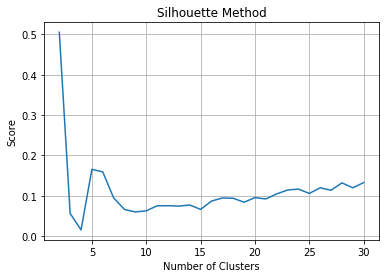

In [22]:
# Determine the optimal k value by identifying the highest score
random_state=0xCAFE
plot_sil(svd_matrix_step2, kmax=30)

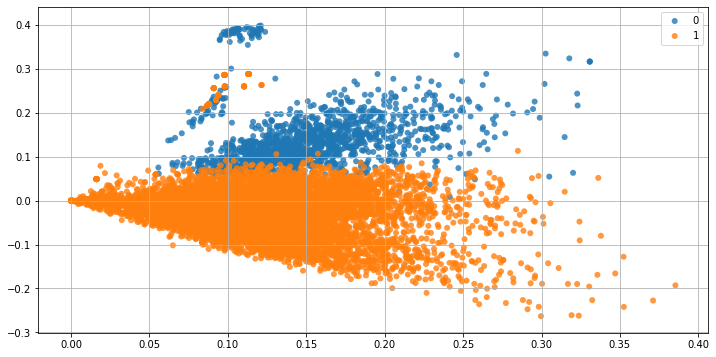

In [23]:
# Show the clustering result in 2D space 
prediction2 = plot_and_predict(svd_matrix_step2, n_clusters=2)

In [24]:
# Show the raw texts in these two groups
n_clusters = 2
for i in range(n_clusters):
    print('%d, The raw texts in group %d:'%(i,i))
    result = raw_articles_data[prediction==0][prediction2==i]['text']   
    display(result)

0, The raw texts in group 0:


1        the npxs token developer aim to have ethereum ...
2        pundi x (currency:npxs) traded 2. u dollar dur...
3        pundi x (currency:npxs) traded 0. pm eastern o...
4        pundi x (currency:npxs) traded down 0. u dolla...
5        pundi x nem (currency:npxsxem) traded down 10....
                               ...                        
11126    pundi x (currency:npxs) traded down 1. u. s. p...
11127    pundi x nem (currency:npxsxem) traded 1. pm ea...
11128    pundi x nem (currency:npxsxem) traded down 7. ...
11129    pundi x nem (currency:npxsxem) traded 0. am et...
11130    pundi x nem (currency:npxsxem) traded 6. u dol...
Name: text, Length: 1375, dtype: object

1, The raw texts in group 1:


0        jan. according to the u. s. national institute...
10       ce 2019 officially start on tuesday and press ...
14       vr gaming. weve had highlight like creed, fire...
15       the industry summary is provided by the analys...
16       we use cooky and other technology to customize...
                               ...                        
11182    microsoft for the mixed reality partnership pr...
11183    ar (ar) app that convert any room to a virtual...
11184    there nothing like a good educational vr (vr) ...
11185    it got a lot of vr and ar exhibit right now, n...
11186    immersive technology adoption rate have steadi...
Name: text, Length: 9703, dtype: object

### Summary
After removing the outliers and reviewing the new clustering result, we find that the articles in group 0 seem to come from the same category regarding cryptocurrency. Therefore, we decide to further analyze the articles in group 0 in the next part. On the other hand, we will keep clustering the articles in group 1 in Section 2.4.

### Part B
Regarding the articles in group 0, we first pick the article whose position is most close to the cluster center as representative. Next, regarding the representative article, we select the words with top-5 highest TFIDF scores as top-5 keywords. After that, we select the articles with top-10 highest sum of TFIDF scores regarding the top-5 keywords as top-10 documents. Then, we select the articles with top-10 highest cosine similarities regarding representative article as top-10 documents. Finally, we select the articles with top-10 highest cosine similarities only calculated by top-5 keywords as top-10 documents.

In [30]:
# Find cluster centers
random_state = 0xCAFE
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm='auto')
fitted = kmeans.fit(svd_matrix_step2)
pred = kmeans.predict(svd_matrix_step2)
centers = fitted.cluster_centers_

In [32]:
# Choose article whose position is most close to the cluster center as representative
closest, _ = pairwise_distances_argmin_min(centers, svd_matrix_step2)
representative_article = new_raw_articles_data['text'][closest[0]]
new_raw_articles_data['title'][closest[0]]

'What Is Tether? - Everything You Need To Know About Tether Cryptocurrency'

In [33]:
# Choose words with top-5 highest TFIDF scores as top-5 keywords
tf_idf_array = tf_idf_norm_step2.toarray()
top5_index = tf_idf_array[closest[0]].argsort()[-5:][::-1]
top5_words = list(np.array(words)[top5_index.tolist()])
top5_words

['tether', 'bitfinex', 'dollar', 'eur', 'currency']

In [34]:
# choose articles with top-10 highest sum of TFIDF scores regarding the top-5 keywords as top-10 documents
sum_tfidf = np.sum(tf_idf_array[:,top5_index],axis=1)
top10_index = sum_tfidf.argsort()[-10:][::-1]
top_articles_q3 = np.array(new_raw_articles_data['text'][top10_index]).tolist()
new_raw_articles_data['title'][top10_index]

570     What Is Tether? - Everything You Need To Know ...
7716      What is a fiat-backed stablecoin? - Coininsider
5702    How to Read Currency Pairs: Forex Quotes Expla...
8268    Bitcoin (BTC) Latest Update: Bitcoin (BTC) Mig...
9944                       Cycle Trading: Dollar Rejected
9592    Bexplus Investment Advice - Profit from Bitcoi...
2224    If Bitcoin Becomes a Store of Value Then it Wi...
6715    USD/CAD Forms Textbook Bear Flag Pattern, 1.31...
9260    Bitcoin [BTC] dominated by stablecoins with re...
2563    Binance Now Trading Cryptos, EUR and GBP at Je...
Name: title, dtype: object

In [35]:
# choose articles with top-10 highest cosine similarities regarding representative article as top-10 documents
c_matrix = cosine_similarity(tf_idf_norm_step2)
array1 = np.squeeze(np.asarray(c_matrix))[closest[0]]
array2 = np.where(array1 > 0)[0]
top10_index2 = array1[array2].argsort()[-10:][::-1]
top_articles_q4 = np.array(new_raw_articles_data['text'][array2[top10_index2]]).tolist()
new_raw_articles_data['title'][array2[top10_index2]]

570     What Is Tether? - Everything You Need To Know ...
7716      What is a fiat-backed stablecoin? - Coininsider
9260    Bitcoin [BTC] dominated by stablecoins with re...
374     New crypto exchange takes on behemoths with ph...
225     Physical Bitcoin Futures Are Coming to Asia Fi...
566            Top 10 Crypto Projects by Tech Development
1144                                                  NaN
588     Top 10 Expectations from the Cryptocurrency Ec...
6482    Crypto Market Wrap: Tron Surges to Seventh, Fl...
9559       Novem To Launch Gold Pegged Stablecoin ‘999.9’
Name: title, dtype: object

In [36]:
# choose articles with top-10 highest cosine similarities only calculated by top-5 keywords as top-10 documents
c_matrix = cosine_similarity(tf_idf_norm_step2[:,top5_index])
array1 = np.squeeze(np.asarray(c_matrix))[closest[0]]
array2 = np.where(array1 > 0)[0]
top10_index3= array1[array2].argsort()[-10:][::-1]
top_articles_q5 = np.array(new_raw_articles_data['text'][array2[top10_index3]]).tolist()
new_raw_articles_data['title'][array2[top10_index3]]

570      What Is Tether? - Everything You Need To Know ...
1701     USB-C VR Extension Adapter for Rift & Windows ...
2968               Drones Create Quite the “Splash” at CES
5937     Five smart ways to use wearable technology in ...
566             Top 10 Crypto Projects by Tech Development
10486    Exclusive: HP's Next-gen VR Headset Aims to Ra...
6460     An In-Depth Look at the Trezor Model T Hardwar...
225      Physical Bitcoin Futures Are Coming to Asia Fi...
218      Circle Reveals $24 Billion Cryptocurrency OTC ...
2739     Hard Fork Countdown: Ethereum’s Thirdening Dra...
Name: title, dtype: object

In [37]:
# Create a dictionary with the above results
Results_Dict = {'Category 1': [representative_article, top5_words, top_articles_q3, top_articles_q4, top_articles_q5]}

### Summary
After the brief analysis, we create a dictionary with all the results toward the group 0. On the other hand, according to the summary of Part A, we will keep clustering the articles in group 1 in the next section.

### 2.4 Dimensionality Reduction and Clustering (3)
### Part A
Since the articles in group 0 are regarded as coming from the same category, we will then remove those articles from our dataset. After that, we will keep utilzing the function created in Section 2.2 to select optimal k value of k-means clustering, cluster the articles in group 1 using k-means clustering with k clusters, and further plot the position of the articles in group 1 in 2D space.

In [38]:
# Deal with the articles in group 0
index, = np.where(prediction2==1)
new_raw_articles_data2 = new_raw_articles_data.iloc[index].reset_index(drop=True)

tf_idf_norm_step3 = tf_idf_norm_step2[prediction2==1]
svd_matrix_step3 = TruncatedSVD(n_components=100, algorithm='randomized', random_state=0xCAFE).fit_transform(tf_idf_norm_step3)

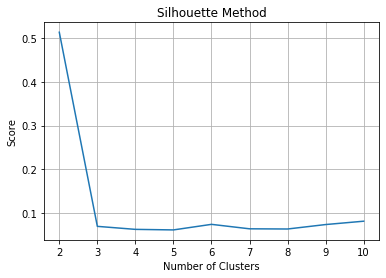

In [47]:
# Determine the optimal k value by identifying the highest score
random_state=0xCAFE
plot_sil(svd_matrix_step3, kmax=10)

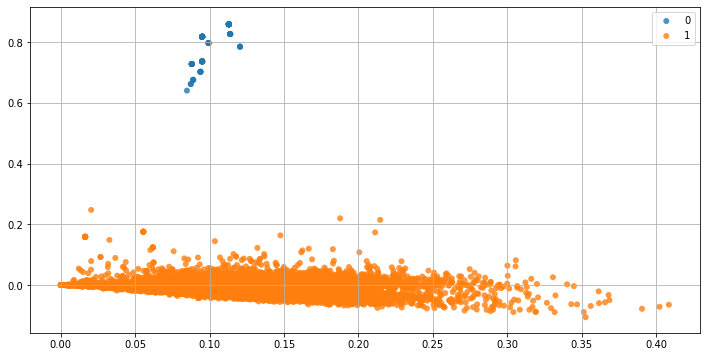

In [48]:
# Show the clustering result in 2D space 
prediction3 = plot_and_predict(svd_matrix_step3, n_clusters=2)

In [49]:
# Show the raw texts in these two groups
n_clusters = 2
for i in range(n_clusters):
    print('%d, The raw texts in group %d:'%(i,i))
    result = raw_articles_data[prediction==0][prediction2==1][prediction3==i]['text'] 
    display(result)

0, The raw texts in group 0:


949      gamesradar+ is part of future plc, an internat...
953      gamesradar+ is part of future plc, an internat...
955      gamesradar+ is part of future plc, an internat...
957      gamesradar+ is part of future plc, an internat...
959      gamesradar+ is part of future plc, an internat...
                               ...                        
10522    pc gamer is part of future plc, an internation...
10523    pc gamer is part of future plc, an internation...
10524    pc gamer is part of future plc, an internation...
11076    what hi fi? future plc, an international mediu...
11176    techradar is part of future plc, an internatio...
Name: text, Length: 93, dtype: object

1, The raw texts in group 1:


0        jan. according to the u. s. national institute...
10       ce 2019 officially start on tuesday and press ...
14       vr gaming. weve had highlight like creed, fire...
15       the industry summary is provided by the analys...
16       we use cooky and other technology to customize...
                               ...                        
11182    microsoft for the mixed reality partnership pr...
11183    ar (ar) app that convert any room to a virtual...
11184    there nothing like a good educational vr (vr) ...
11185    it got a lot of vr and ar exhibit right now, n...
11186    immersive technology adoption rate have steadi...
Name: text, Length: 9610, dtype: object

### Summary
After reviewing the new clustering result, we find that the articles in group 0 seem to come from the same category regarding games and technology. Therefore, we decide to further analyze the articles in group 0 in the next part. On the other hand, we could keep clustering the articles in group 1 since the articles in group 1 seem to come from the different categories.

### Part B
Similarly, regarding the articles in group 0, we first pick the article whose position is most close to the cluster center as representative. Next, regarding the representative article, we select the words with top-5 highest TFIDF scores as top-5 keywords. After that, we select the articles with top-10 highest sum of TFIDF scores regarding the top-5 keywords as top-10 documents. Then, we select the articles with top-10 highest cosine similarities regarding representative article as top-10 documents. Finally, we select the articles with top-10 highest cosine similarities only calculated by top-5 keywords as top-10 documents.

In [54]:
# Find cluster centers
random_state = 0xCAFE
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm='auto')
fitted = kmeans.fit(svd_matrix_step3)
pred = kmeans.predict(svd_matrix_step3)
centers = fitted.cluster_centers_

In [55]:
# Choose article whose position is most close to the cluster center as representative
closest, _ = pairwise_distances_argmin_min(centers, svd_matrix_step3)
representative_article = new_raw_articles_data2['text'][closest[0]]
new_raw_articles_data2['title'][closest[0]]

'Roku’s free streaming service is now available on iOS devices'

In [56]:
# Choose words with top-5 highest TFIDF scores as top-5 keywords
tf_idf_array = tf_idf_norm_step3.toarray()
top5_index = tf_idf_array[closest[0]].argsort()[-5:][::-1]
top5_words = list(np.array(words)[top5_index.tolist()])
top5_words

['techradar', 'plc', 'future', 'publisher', 'international']

In [57]:
# choose articles with top-10 highest sum of TFIDF scores regarding the top-5 keywords as top-10 documents
sum_tfidf = np.sum(tf_idf_array[:,top5_index],axis=1)
top10_index = sum_tfidf.argsort()[-10:][::-1]
top_articles_q3 = np.array(new_raw_articles_data2['text'][top10_index]).tolist()
new_raw_articles_data2['title'][top10_index]

7944    iPhone 11 reportedly not getting a fast-chargi...
4411    Samsung is switching to eco-friendly phone pac...
7946    Microsoft might not be killing off Paint after...
7943    Adobe gives Lightroom a boost with Sensei-powe...
7942    Official Samsung Galaxy S10 cases leak as the ...
9692    Pimax’s ‘8K’ ultra-wide high-resolution VR hea...
4412    Serious Apple glitch lets users snoop on peopl...
4413    Today-only: cheap Chromebooks, gaming PC and m...
4408    Roku’s free streaming service is now available...
3155                           Steam now has 30,000 games
Name: title, dtype: object

In [59]:
# choose articles with top-10 highest cosine similarities regarding representative article as top-10 documents
c_matrix = cosine_similarity(tf_idf_norm_step3)
array1 = np.squeeze(np.asarray(c_matrix))[closest[0]]
array2 = np.where(array1 > 0)[0]
top10_index2 = array1[array2].argsort()[-10:][::-1]
top_articles_q4 = np.array(new_raw_articles_data2['text'][array2[top10_index2]]).tolist()
new_raw_articles_data2['title'][array2[top10_index2]]

7944    iPhone 11 reportedly not getting a fast-chargi...
4408    Roku’s free streaming service is now available...
4413    Today-only: cheap Chromebooks, gaming PC and m...
7942    Official Samsung Galaxy S10 cases leak as the ...
7943    Adobe gives Lightroom a boost with Sensei-powe...
7946    Microsoft might not be killing off Paint after...
4411    Samsung is switching to eco-friendly phone pac...
9692    Pimax’s ‘8K’ ultra-wide high-resolution VR hea...
4412    Serious Apple glitch lets users snoop on peopl...
5710    Farming Simulator goes esports with a €250,000...
Name: title, dtype: object

In [60]:
# choose articles with top-10 highest cosine similarities only calculated by top-5 keywords as top-10 documents
c_matrix = cosine_similarity(tf_idf_norm_step3[:,top5_index])
array1 = np.squeeze(np.asarray(c_matrix))[closest[0]]
array2 = np.where(array1 > 0)[0]
top10_index3= array1[array2].argsort()[-10:][::-1]
top_articles_q5 = np.array(new_raw_articles_data2['text'][array2[top10_index3]]).tolist()
new_raw_articles_data2['title'][array2[top10_index3]]

7943    Adobe gives Lightroom a boost with Sensei-powe...
7944    iPhone 11 reportedly not getting a fast-chargi...
7942    Official Samsung Galaxy S10 cases leak as the ...
9692    Pimax’s ‘8K’ ultra-wide high-resolution VR hea...
4411    Samsung is switching to eco-friendly phone pac...
4413    Today-only: cheap Chromebooks, gaming PC and m...
4408    Roku’s free streaming service is now available...
7946    Microsoft might not be killing off Paint after...
4412    Serious Apple glitch lets users snoop on peopl...
5711    Play Stormdivers, Housemarque's battle royale,...
Name: title, dtype: object

In [61]:
# Add the above results to the dictionary
Results_Dict['Category 2'] = [representative_article, top5_words, top_articles_q3, top_articles_q4, top_articles_q5]

### Summary 
After the brief analysis about group 0, we add all the results toward the group 0 to the dictionary created in Part B of Section 2.3.

## Chapter 3 Conclusion and Answering Questions
Apparently, we didn't finish our work. According to the summary in Part A of Section 2.4, we should keep clustering the articles since the rest articles seem to come from the different categories. However, we did provide a framework to deal with this kind of text clustering problem.

So far, we already identified two categories out of the articles. One category is about cryptocurrency (Category 1) while another one is about games and technology (Category 2). Most importanly, we stored the analysis results of each category in a dictionary called `Results_Dict`. Therefore, on the basis of the dictionary, we could try to answer the following questions.

Q1: Please plot the position of the articles in two dimensional space and cluster the articles in several groups. Then, you need to pick the representative article toward each group. (note: you have to explain the reason of picking group number)

Ans: We plot the position of the articles in 2D space and cluster the articles in several groups by using truncated SVD and k-means clustering, which could be found in Chapter 2. Beside, we pick group number by using silhouette method, which could also be found in Chapter 2. Regarding the representative article toward each group, if now we want to know the representative article of Category 1, we could execute the code as follows:

In [62]:
Results_Dict['Category 1'][0]

"born with the idea of having a stable cryptocurrency that can be used a digital dollars, tether is a cryptocurrency with a value meant to mirror the value the u. s. tether is a cryptocurrency with token issued by tether limited, and claim to be backed up by u. s. tether platform. tether which come with the trading abbreviation usdt, belongs to a group of cryptocurrency, with which one can transfer amount in real time and exchange them with other currencies. tether is supported by several blockchain platform such a kraken and bitfinex. it is also one of the stable coin because it act a an alternative to u. s. it act a a stable dollar for many exchanges, and is also one of the most stable option available. unlike other cryptocurrency, tether is supposed to be backed by dollar kept in reserve in a 1:1 ratio, which is a big selling point, and a big problem in the untethered and decentralized crypto arena. although it claim to trade at $1 on all exchanges, the actual price seems to fluctua

Q2: Based on the Q1, what are the top-5 keywords of each representative article.

Ans: If now we want to know the top-5 keywords of the representative article of Category 1, we could execute the code as follows:

In [64]:
Results_Dict['Category 1'][1]

['tether', 'bitfinex', 'dollar', 'eur', 'currency']

Q3: Based on the Q1 and Q2, please rank the top-10 document order with the top-5 keywords from the representative article toward each group.

Ans: If now we want to know the top-10 document order with the top-5 keywords from the representative article toward Category 1, we could execute the code as follows:

In [65]:
Results_Dict['Category 1'][2]

["born with the idea of having a stable cryptocurrency that can be used a digital dollars, tether is a cryptocurrency with a value meant to mirror the value the u. s. tether is a cryptocurrency with token issued by tether limited, and claim to be backed up by u. s. tether platform. tether which come with the trading abbreviation usdt, belongs to a group of cryptocurrency, with which one can transfer amount in real time and exchange them with other currencies. tether is supported by several blockchain platform such a kraken and bitfinex. it is also one of the stable coin because it act a an alternative to u. s. it act a a stable dollar for many exchanges, and is also one of the most stable option available. unlike other cryptocurrency, tether is supposed to be backed by dollar kept in reserve in a 1:1 ratio, which is a big selling point, and a big problem in the untethered and decentralized crypto arena. although it claim to trade at $1 on all exchanges, the actual price seems to fluctu

In [66]:
len(Results_Dict['Category 1'][2])

10

Q4: Based on the Q1 and Q2, please rank the top-10 document order with the content from the representative article toward each group.

Ans: If now we want to know the top-10 document order with the content from the representative article toward Category 1, we could execute the code as follows:

In [67]:
Results_Dict['Category 1'][3]

["born with the idea of having a stable cryptocurrency that can be used a digital dollars, tether is a cryptocurrency with a value meant to mirror the value the u. s. tether is a cryptocurrency with token issued by tether limited, and claim to be backed up by u. s. tether platform. tether which come with the trading abbreviation usdt, belongs to a group of cryptocurrency, with which one can transfer amount in real time and exchange them with other currencies. tether is supported by several blockchain platform such a kraken and bitfinex. it is also one of the stable coin because it act a an alternative to u. s. it act a a stable dollar for many exchanges, and is also one of the most stable option available. unlike other cryptocurrency, tether is supposed to be backed by dollar kept in reserve in a 1:1 ratio, which is a big selling point, and a big problem in the untethered and decentralized crypto arena. although it claim to trade at $1 on all exchanges, the actual price seems to fluctu

In [68]:
len(Results_Dict['Category 1'][3])

10

Q5: Please combine both methods you applied in the Q3 and Q4 to output the similar format result.

Ans: If now we want to know the top-10 document order toward Category 1 based on the methods we applied in the Q3 and Q4, we could execute the code as follows:

In [69]:
Results_Dict['Category 1'][4]

["born with the idea of having a stable cryptocurrency that can be used a digital dollars, tether is a cryptocurrency with a value meant to mirror the value the u. s. tether is a cryptocurrency with token issued by tether limited, and claim to be backed up by u. s. tether platform. tether which come with the trading abbreviation usdt, belongs to a group of cryptocurrency, with which one can transfer amount in real time and exchange them with other currencies. tether is supported by several blockchain platform such a kraken and bitfinex. it is also one of the stable coin because it act a an alternative to u. s. it act a a stable dollar for many exchanges, and is also one of the most stable option available. unlike other cryptocurrency, tether is supposed to be backed by dollar kept in reserve in a 1:1 ratio, which is a big selling point, and a big problem in the untethered and decentralized crypto arena. although it claim to trade at $1 on all exchanges, the actual price seems to fluctu

In [70]:
len(Results_Dict['Category 1'][4])

10